# Importando as dependencias

In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import json
from PIL import Image, ImageChops, ImageEnhance

# Data Set
Carregando o DataSet de imagens originais e manipuladas

In [2]:
image_height = 128
image_width = 128
image_color_channel = 3
image_color_channel_size = 255
image_size = (image_height, image_width)
image_shape = image_size + (image_color_channel,)

batch_size = 24
class_names = ['authentic', 'tampered']

In [3]:
# dataset_dir = os.path.join(os.getcwd(), 'data_sets', 'xrays')
# CASIA1 CASIA2 ELA_CASIA1
dataset_dir = os.path.join('D:', 'data_sets', 'general_image_tampering', 'CASIA', 'CASIA1')

original_dir = os.path.join(dataset_dir, 'authentic')
tampered_dir = os.path.join(dataset_dir, 'tampered')

original_images = os.listdir(original_dir)
tampered_images = os.listdir(tampered_dir)

print('Number of original images: ', len(original_images))

print('Number of tampered images: ', len(tampered_images))

Number of original images:  800
Number of tampered images:  921


# Batch Creation

In [6]:
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    batch_size = batch_size,
    image_size = image_size,
    shuffle = True,
    seed = 42,
    validation_split = 0.2,
    subset = 'training'
)

Found 1721 files belonging to 2 classes.
Using 1377 files for training.


In [7]:
dataset_validation = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    batch_size = batch_size,
    image_size = image_size,
    shuffle = True,
    seed = 42,
    validation_split = 0.2,
    subset = 'validation'
)

Found 1721 files belonging to 2 classes.
Using 344 files for validation.


In [8]:
dataset_validation_cardinality = tf.data.experimental.cardinality(dataset_validation)
dataset_validation_batches = dataset_validation_cardinality // 5

# Utilizado para testar o modelo depois do término do treino do modelo
dataset_test = dataset_validation.take(dataset_validation_batches)
# Utilizado para avaliar o modelo ainda durante o treinamento
dataset_validation = dataset_validation.skip(dataset_validation_batches)

print('Number of training batches: ', tf.data.experimental.cardinality(dataset_train))

print('Number of validation batches: ', tf.data.experimental.cardinality(dataset_validation))

print('Number of test batches: ', tf.data.experimental.cardinality(dataset_test))

Number of training batches:  tf.Tensor(58, shape=(), dtype=int64)
Number of validation batches:  tf.Tensor(12, shape=(), dtype=int64)
Number of test batches:  tf.Tensor(3, shape=(), dtype=int64)


# Data Augmentation

In [9]:
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

# Feature Extraction

In [10]:
feature_extractor = tf.keras.applications.VGG16(input_shape=image_shape, include_top=False, weights='imagenet')
feature_extractor.trainable = False

feature_extractor.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

# Model

In [11]:
epochs = 20
learning_rate = 1e-4

In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=image_shape),
    data_augmentation,
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(
    tf.keras.optimizers.Adam(learning_rate = learning_rate),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1)                 8193      
                                                                 
Total params: 14722881 (56.16 MB)
Trainable params: 8193 (32.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [20]:
history = model.fit(
    dataset_train,
    validation_data = dataset_validation,
    epochs = epochs
)
history_dict = history.history

Epoch 1/20


58/58 [==============================] - 106s 2s/step - loss: 4.6807 - binary_accuracy: 0.5047 - precision_1: 0.5294 - recall_1: 0.5338 - auc: 0.5103 - val_loss: 5.6749 - val_binary_accuracy: 0.5184 - val_precision_1: 0.5918 - val_recall_1: 0.5506 - val_auc: 0.5169
Epoch 2/20
58/58 [==============================] - 111s 2s/step - loss: 4.4578 - binary_accuracy: 0.5113 - precision_1: 0.5352 - recall_1: 0.5448 - auc: 0.5206 - val_loss: 5.3121 - val_binary_accuracy: 0.5331 - val_precision_1: 0.6103 - val_recall_1: 0.5287 - val_auc: 0.5358
Epoch 3/20
58/58 [==============================] - 110s 2s/step - loss: 4.0366 - binary_accuracy: 0.5200 - precision_1: 0.5441 - recall_1: 0.5448 - auc: 0.5213 - val_loss: 5.2891 - val_binary_accuracy: 0.5551 - val_precision_1: 0.6475 - val_recall_1: 0.5556 - val_auc: 0.5564
Epoch 4/20
58/58 [==============================] - 111s 2s/step - loss: 3.6459 - binary_accuracy: 0.5338 - precision_1: 0.5580 - recall_1: 0.5503 - auc: 0.5356 - val_loss: 4.9183 

# Save and Load Model

In [36]:
path = os.path.join('models', 'VGG16_IMAGENET_CASIA1_20_EPOCHS')

model.save(os.path.join(path,'model.h5'))

json.dump(history_dict, open(os.path.join(path, 'model_history.json'), 'w'))

c:\Repositories\projects\my-projects\tensor-flow-test\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
path = os.path.join('models', 'ELA_VGG16_IMAGENET_CASIA1_50_EPOCHS')

model = tf.keras.models.load_model(os.path.join(path, 'model.h5'))

history_dict = json.load(open(os.path.join(path, 'model_history.json'), 'r'))

# Model Evaluation

Text(0.5, 0.98, 'Metrics')

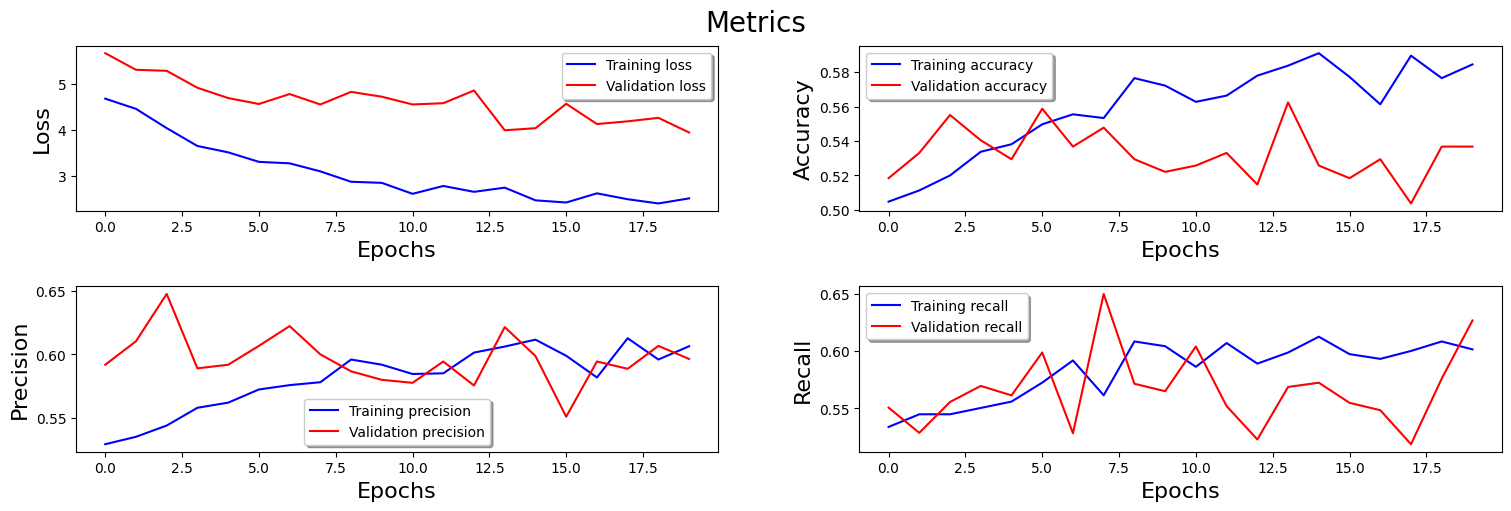

In [50]:
fig, ax = plt.subplots(2,2,figsize=(15,5), gridspec_kw={'hspace': 0.1, 'wspace': 0.1}, constrained_layout=True)

ax[0, 0].plot(history_dict['loss'], color='b', label = "Training loss")
ax[0, 0].plot(history_dict['val_loss'], color='r', label = "Validation loss")
ax[0, 0].set_xlabel('Epochs',fontsize=16)
ax[0, 0].set_ylabel('Loss',fontsize=16)
legend = ax[0, 0].legend(loc='best', shadow=True)

ax[0, 1].plot(history_dict['binary_accuracy'], color='b', label = "Training accuracy")
ax[0, 1].plot(history_dict['val_binary_accuracy'], color='r',label = "Validation accuracy")
ax[0, 1].set_xlabel('Epochs',fontsize=16)
ax[0, 1].set_ylabel('Accuracy',fontsize=16)
legend = ax[0, 1].legend(loc='best', shadow=True)

ax[1, 0].plot(history_dict['precision_1'], color='b', label = "Training precision")
ax[1, 0].plot(history_dict['val_precision_1'], color='r',label = "Validation precision")
ax[1, 0].set_xlabel('Epochs',fontsize=16)
ax[1, 0].set_ylabel('Precision',fontsize=16)
legend = ax[1, 0].legend(loc='best', shadow=True)

ax[1, 1].plot(history_dict['recall_1'], color='b', label = "Training recall")
ax[1, 1].plot(history_dict['val_recall_1'], color='r',label = "Validation recall")
ax[1, 1].set_xlabel('Epochs',fontsize=16)
ax[1, 1].set_ylabel('Recall',fontsize=16)
legend = ax[1, 1].legend(loc='best', shadow=True)

fig.suptitle('Metrics',fontsize=20)

In [45]:
(dataset_test_loss, dataset_test_accuracy, dataset_test_precision, dataset_test_recall, dataset_test_auc) = model.evaluate(dataset_test)

print('Dataset Test Loss:      %s' % dataset_test_loss)
print('Dataset Test Accuracy:  %s' % dataset_test_accuracy)
print('Dataset Test Precision: %s' % dataset_test_precision)
print('Dataset Test Recall:    %s' % dataset_test_recall)
print('Dataset Test AUC:       %s' % dataset_test_auc)

3/3 [==============================] - 3s 830ms/step - loss: 4.4443 - binary_accuracy: 0.4861 - precision_1: 0.5652 - recall_1: 0.6047 - auc: 0.4447
Dataset Test Loss:      4.444280624389648
Dataset Test Accuracy:  0.4861111044883728
Dataset Test Precision: 0.5652173757553101
Dataset Test Recall:    0.604651153087616
Dataset Test AUC:       0.4446672201156616


In [46]:
def plot_dataset_predictions(dataset):

    features, labels = dataset_test.as_numpy_iterator().next()

    predictions = model.predict_on_batch(features).flatten()
    predictions = tf.where(predictions < 0.5, 0, 1)

    print('Labels:      %s' % labels)
    print('Predictions: %s' % predictions.numpy())

    plt.gcf().clear()
    plt.figure(figsize = (15, 15))

    for i in range(16):

        plt.subplot(4, 4, i + 1)
        plt.axis('off')
        
        plt.imshow(features[i].astype('uint8'))
        plt.title(class_names[predictions[i]] + ' (' + class_names[labels[i]] + ')')

Labels:      [0 1 1 0 1 1 0 1 1 1 0 0 1 1 0 0 1 0 0 1 0 1 0 1]
Predictions: [0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 0]


<Figure size 640x480 with 0 Axes>

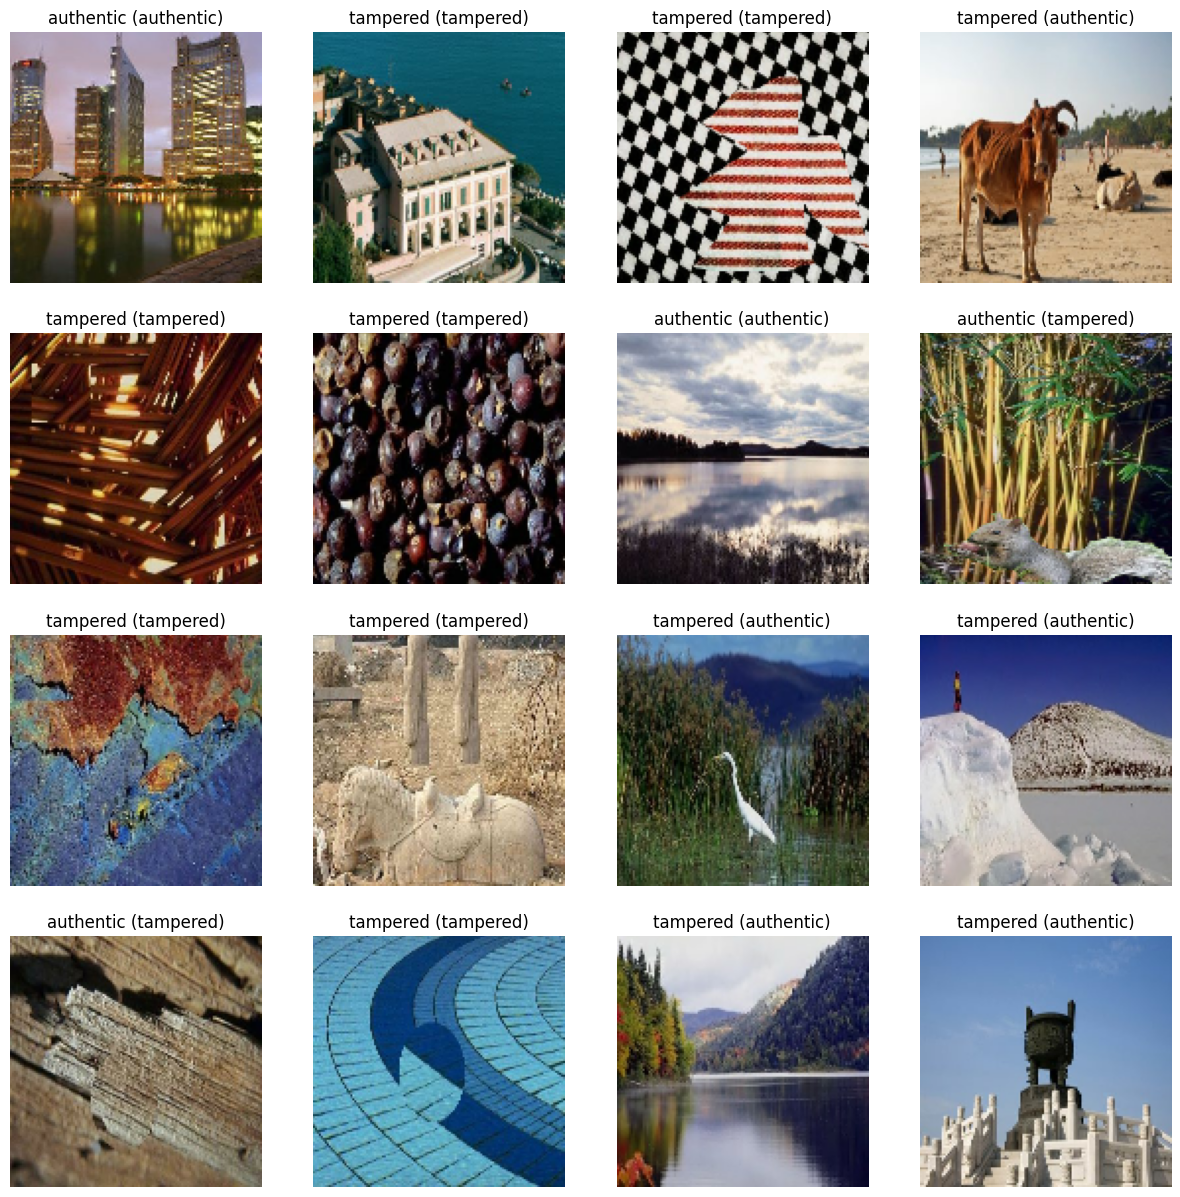

In [47]:
plot_dataset_predictions(dataset_test)

In [14]:
image_path = './F2.png'
image_to_predict = tf.keras.preprocessing.image.load_img(image_path, target_size = image_size)
image_to_predict = tf.keras.preprocessing.image.img_to_array(image_to_predict)
image_to_predict = tf.expand_dims(image_to_predict, 0)

prediction = model.predict(image_to_predict)
print('Prediction: %s' % prediction)
prediction = tf.where(prediction < 0.5, 0, 1)

print('Prediction: %s' % prediction.numpy())

FileNotFoundError: [Errno 2] No such file or directory: './F2.png'